<a href="https://colab.research.google.com/github/patbaa/physdl/blob/master/notebooks/07/model_vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What  excites a neuron?

---

We know that the final units are repsonding to the classes, that's why the predictions are correct.

If we look at the first some filters of networks we usually see some low level image component filters, edges, colorful blobs ets. (Image?)

But what is in between? What are intermediate representations?

---

We could look at the intermediate representations, but actually it's hard to decipher them. The feature maps look like a bunch of deformed/transformed 'images'.

---

Instead, we will run some thousands of images through a convolutional net, and collect those image patches which result in the strongest activation for a given intermediate feature map.

This way we hope to understand what are the qualities of the original image, which that filter is sensitive to.

So we hope to understand what that featue map **represents**.


----

#### Resources:
From the article about ["Visualizing and understanding convolutional neural networks"](https://arxiv.org/abs/1311.2901)

Video of a [presentation on youtube](https://www.youtube.com/watch?v=ghEmQSxT6tw)

A lot more about the topic and related things in the Stanford cs231 course [slides](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture12.pdf).

----

In [0]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [0]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dense, Dropout, Flatten

from PIL import Image

Using TensorFlow backend.


## Define the  Vgg16 model


- 2nd place in ILSVRC 2014
- the best single model of the competition ( more tricks in the winner )
- [arxiv paper](https://arxiv.org/abs/1409.1556)

A few architectrural changes compared to LeNet.

* ReLU non-linearity instead of tanh or sigmoid
* move to 3x3 conv ( and 2 convolutions per blocks instead of 1 ) ('deeper')
* larger images -> repeat blocks multiple times to achieve large FOV for last conv untis  ('deeper')
* richer/more data: more filters ('wider' model)
* And a regularization layer: Dropout ([link to orignal paper](www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    * during training randomly knock out a fraction of neurons (0 output)
    * during testing switch all on ( multiply outputs with the dropout probabilty )
    * the results is something like an 'ensemble' of slightly different networks
    * it's popularity has declined but still used in the best "inception" networks 


(Note the functional API.)


#### This time produce intermediate layer activations too!

In [0]:
def VGG16():
    """
    Return a vgg16 model.
    
    Keras has a built in vgg16 model which omits Dropouts.
    I don't want to omit the dropouts as they are part of
    the original vgg16 model. therefore I have to define the
    vgg16 model myself.
    """
    img_input = Input(shape=(224,224,3),name='input')

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    b1c2 = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(b1c2)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    b2c2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(b2c2)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    b3c3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(b3c3)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    b4c3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(b4c3)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    b5c3 = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(b5c3)

    # Classification block
    x = Flatten(name='flatten')(x)
    x = Dropout(0.5,name='Dropout1')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5,name='Dropout2')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(1000, activation='softmax', name='predictions')(x)

    vgg16 = Model(inputs=img_input, outputs=[x,b3c3,b4c3,b5c3])
    
    return vgg16

[Download model parameters from Keras official](https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5)

In [0]:
vgg16 = VGG16()  # initialize model
# load weights
vgg16.load_weights('../../data/vgg16_weights_tf_dim_ordering_tf_kernels.h5')
vgg16.summary() # just check it

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Let's define a prediction function

In [0]:
def predict1(model,img):
    """Predict arbitrary image."""
    # resize im to input size
    # aspect ratios are not respected here...
    # works well with instagram
    img = img.resize((224,224))  
    
    # turn to numpy array from PIL Image
    im = array(img)
    
    # watch out images were trained as BGR (opencv!)
    # PIL load images to rgb!!!
    im = roll(im, 1, axis=-1)   # roll it
    
    # if bw make it not
    if len(im.shape)!=3:
        bwim=im
        im = np.zeros((224,224,3))
        im[...,0],im[...,1],im[...,2] = bwim,bwim,bwim
    
    # scale them as they did during training
    im = im.astype('float64')  # to float!
    im[:,:,0] -= 103.939  # color mean in training set
    im[:,:,1] -= 116.779  # color mean in training set
    im[:,:,2] -= 123.68  # color mean in training set
    
    im = im.reshape(-1,224,224,3)  # resize for 'batch'
    preds = model.predict(im)   # predict
    
    return preds

## Use a bunch of ILSVRC validation images

- Download data from the challenge: http://www.image-net.org/challenges/LSVRC/


In [0]:
from glob import glob
im_fns = sorted(glob('../../data/val_ims/ILSVRC2012_val_0*.JPEG'))

### Run them through the net ( watch out, it takes long time )

It actually takes so long, because I was running it on my laptop cpu.

In [0]:
%%time

N = 10000

b3c3,b4c3,b5c3 = [],[],[]
for fn in im_fns[:N]:
    p = predict1(vgg16,Image.open(fn))  # predict
    # savre only first 20 filters
    b3c3.append(p[1][...,:20])
    b4c3.append(p[2][...,:20])
    b5c3.append(p[3][...,:20])

b3c3,b4c3,b5c3 = map(vstack,[b3c3,b4c3,b5c3])

# save for later
np.save('b3c3',b3c3)
np.save('b4c3',b4c3)
np.save('b5c3',b5c3)

CPU times: user 5h 15min 56s, sys: 12min 1s, total: 5h 27min 57s
Wall time: 1h 37min 30s


In [0]:
b3c3,b4c3,b5c3 = map(np.load,['b3c3.npy','b4c3.npy','b5c3.npy'])

### Calculate the top some image regions across all images, which had the strongest activation in a filter 

First we locate the top activations. The we know which image it it, and where is the position in the given layer. 

From this position we can calculate the region of the original image, which is the Field of View FoV of that neuron. ( Remember: convolutions spread information to close neighbors, max pooling collects information from a patch.)

In [0]:
def top_act(layers, layer_name, filt_idx, n_top=1):
    """Get image indices and fov of top activation for a filter."""    
    acts = array(layers[...,filt_idx])  # copy the layer
    
    im_idx, boxes, maxacts = [],[],[]
    for j in xrange(n_top):
        # get indices of maximum activations
        maxacts.append(acts.max())
        i_im,i_y,i_x = np.unravel_index(acts.argmax(), acts.shape)
        im_idx.append(i_im)  # save im idx
        # calculate FOV for the neuron
        boxes.append(get_fov(layer_name,i_y,i_x))
        
        #remove image from the activations
        #acts = np.delete(acts,i_im,0)    
        acts[i_im,...] = 0
        
    return im_idx,boxes,maxacts


def get_fov(layer_name,i_y,i_x):
    """Get the field of view for a layer and position."""
    if layer_name=='b5c3':
        x1 = max(0,(((((i_x-3)*2 -3)*2-3)*2-2)*2)-2)
        y1 = max(0,(((((i_y-3)*2 -3)*2-3)*2-2)*2)-2)
        x2 = min(223,(((((i_x+3)*2+1 +3)*2+1+3)*2+1+2)*2)+1+2)
        y2 = min(223,(((((i_y+3)*2+1 +3)*2+1+3)*2+1+2)*2)+1+2)
    elif layer_name=='b4c3':
        x1 = max(0,((((i_x-3)*2 -3)*2-2)*2)-2)
        y1 = max(0,((((i_y-3)*2 -3)*2-2)*2)-2)
        x2 = min(223,((((i_x+3)*2+1 +3)*2+1+2)*2)+1+2)
        y2 = min(223,((((i_y+3)*2+1 +3)*2+1+2)*2)+1+2)
    elif layer_name=='b3c3':
        x1 = max(0,(((i_x-3)*2-2)*2)-2)
        y1 = max(0,(((i_y-3)*2-2)*2)-2)
        x2 = min(223,(((i_x+3)*2+1 +2)*2)+1+2)
        y2 = min(223,(((i_y+3)*2+1 +2)*2)+1+2)
    else:
        print "what"
    return x1,y1,x2,y2

### Plot the top ativating image patches for a filter in the last convolutional layer B5C3

In [0]:
def plot_top_ims(im_idx):
    """Plot the top activating images."""
    figsize(9,9)
    f,a = subplots(3,3)
    for i in [0,1,2]:
        for j in [0,1,2]:
            im = Image.open(im_fns[im_idx[i*3+j]])
            a[i][j].imshow(im)
            a[i][j].axis('off')
    plt.tight_layout()
    
    
def plot_top_boxes(im_idx, boxes):
    """Plot the top activating images."""
    figsize(9,9)
    f,a = subplots(3,3)
    for i in [0,1,2]:
        for j in [0,1,2]:
            im = Image.open(im_fns[im_idx[i*3+j]])
            b = boxes[i*3+j]  # get box coords
            # rescale to original image scale
            x1 = im.size[0]*b[0]/224.
            y1 = im.size[1]*b[1]/224.
            x2 = im.size[0]*b[2]/224.
            y2 = im.size[1]*b[3]/224.
            a[i][j].imshow(im.crop([x1,y1,x2,y2]))
            a[i][j].axis('off')
    plt.tight_layout()

## After manual inspection I have collected some interesting feature maps





### Block 3 conv 3

filter idx:

- 3: dots
- 9: blue blobs

Full images

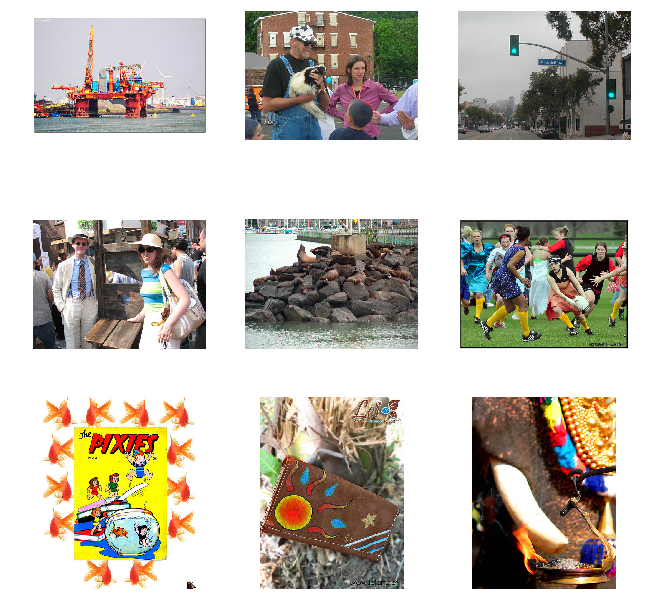

In [0]:
im_idx, boxes, maxacts = top_act(b3c3,'b3c3',filt_idx=9,n_top=10)
plot_top_ims(im_idx)

The 'exciting' patches

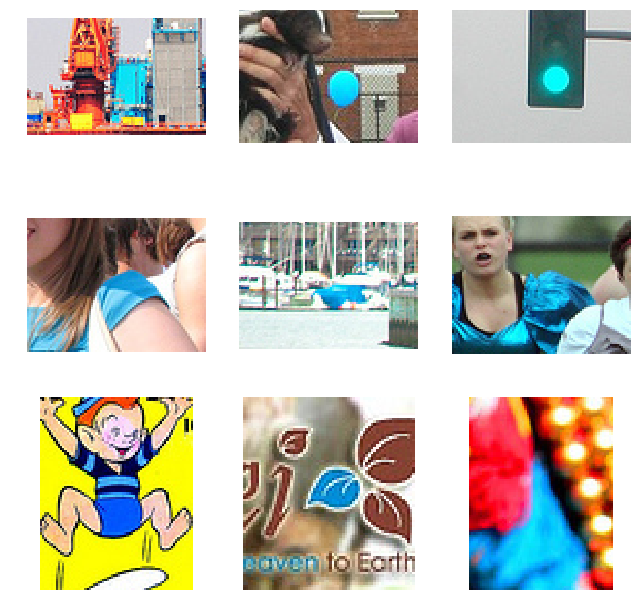

In [0]:
plot_top_boxes(im_idx,boxes)

----

### Block 4 conv 3
 
- 1: flowers/radial lines
- 3: legs
- 12: wheels

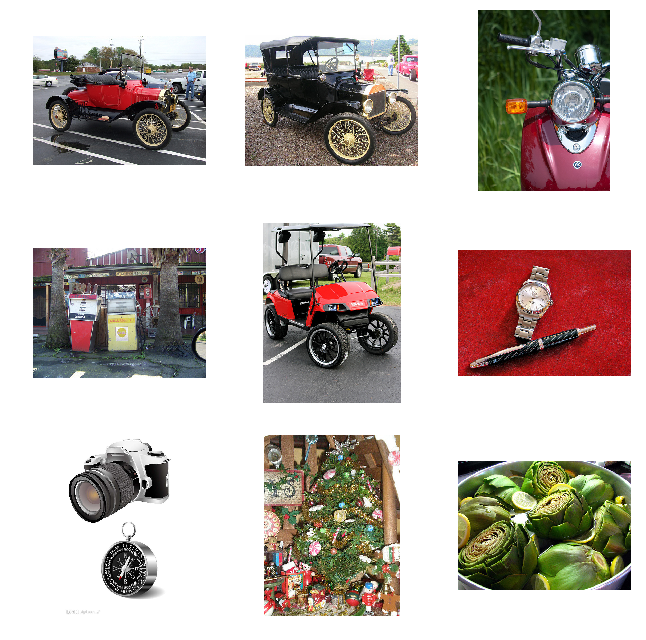

In [0]:
im_idx, boxes, maxacts = top_act(b4c3,'b4c3',filt_idx=12,n_top=10)
plot_top_ims(im_idx)

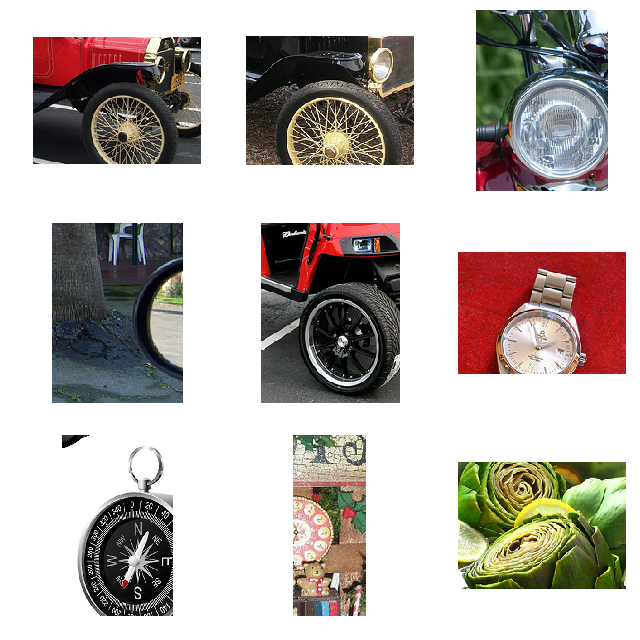

In [0]:
plot_top_boxes(im_idx,boxes)

---

### Block 5 conv 3 ( last conv layer)

- 0: a special spider
- 3: circes
- 6: digital watch displays!
- 7: x-es?
- 10: suits
- 11: masks, and the weird spider?
- 14: locks
- 18: yellow fruits/vegetables 
- 19: vans




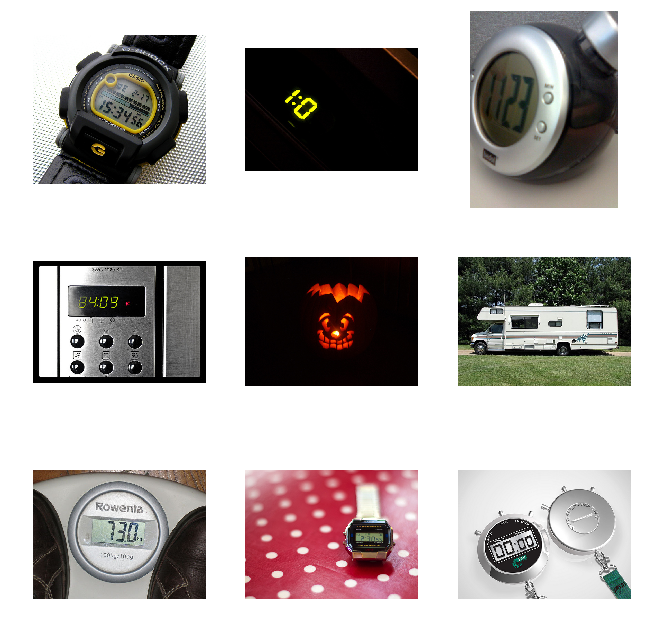

In [0]:
im_idx, boxes, maxacts = top_act(b5c3,'b5c3',filt_idx=6,n_top=10)
plot_top_ims(im_idx)

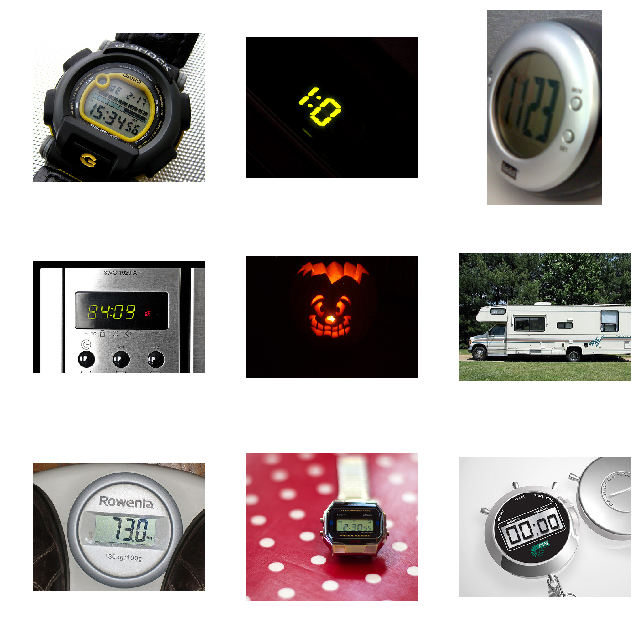

In [0]:
plot_top_boxes(im_idx,boxes)

----


## There is semantic hierarchy in the network


Seems like the layers represent gradually more and more complex semantic structures in the original image.


If you are interested it's highly recommended to go deeper in the topic, this was really just a small demonstation. 